### Anomalies in Time Series Data
#### Lesson Goals
- Use entropy as a quick way to identify fields that may have anomalies.
- Use statistical properties to flag the data points that deviate from the expected.
#### The Data
- Logs of API requests to our data containing sales information about our stores and items.
- Type of target variable: Continuous or Discrete
- Type of observations: Time Series or Point in Time
#### The Questions
- Are there unusual IP addresses accessing our data via the API?
- Have we seen any spikes or unusual patterns in the size of requests?
- In general: Does this new value deviate from what we would expect based on historical data? If so, is it something to be concerned about? Remember, we aren't detecting anomalies for the sake of detecting anomalies.

In [3]:
# imports 
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

#### Acquiring data

In [4]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df = pd.read_csv('https://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

In [5]:
# narrowing df to only the variables we need
df = df[['ip', 'timestamp', 'size']]

#### Explore IP Address
In this sample data, it's pretty easy to take a look at value counts to see those IP's that are rare. However, usually the data is much, much larger and looking at simple value counts is not going to be enough.

In [6]:
def compute_entropy(series):
    counts = series.value_counts()
    if len(counts)==1:
        ent = 0
    else:
        value, counts = np.unique(series, return_counts=True)
        ent = entropy(counts, base=None)
    return ent

In [7]:
compute_entropy(df.ip)

0.5648495339393655

#### Prepare Data to Explore Size
First, we will resample the existing data to 30 minute increments.

In [8]:
df.head()

,ip,timestamp,size
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],512495
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],3561
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],510103
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],510003
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],511963


In [9]:
# select timestamp
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp = pd.to_datetime(df.timestamp.str.replace(':', ' ', 1))
df = df.set_index('timestamp')
df = df[['size']].resample('1d').sum()

In [10]:
df = df.fillna(value=0)
df.describe()

,size
count,2.000000e+00
mean,3.143457e+09
std,3.305049e+09
min,8.064345e+08
25%,1.974946e+09
50%,3.143457e+09
75%,4.311968e+09
max,5.480479e+09


#### Aside: Simulate some new data to manufacture some anomalies
Now, let's create a new dataframe that extends our data another year or so.

In [12]:
new = pd.DataFrame([["[18/Apr/2019:00:00:00+0000]", 0],
                    ["[15/Mar/2020:00:00:00+0000]", 0]], columns=['timestamp','size'])

In [13]:
# resampling
new.timestamp = new.timestamp.str.replace(r'(\[|\])', '', regex=True)
new.timestamp = pd.to_datetime(new.timestamp.str.replace(':', ' ', 1))
new = new.set_index('timestamp')
new = new.resample('1d').sum()

In [14]:
new = new.fillna(value=0)
new.tail()

,size
timestamp,
2020-03-11 00:00:00+00:00,0
2020-03-12 00:00:00+00:00,0
2020-03-13 00:00:00+00:00,0
2020-03-14 00:00:00+00:00,0
2020-03-15 00:00:00+00:00,0


In [15]:
# get mean and standard deviation for randomly generating some data. 
mean = df['size'].mean()
std = df['size'].std()

Fill values with random number between [0, mean+2*standard deviation].

In [17]:
# new['size'] = new['size'].apply(lambda x: max(np.rint(np.random.normal(mean, std)), 0) if x==0 else x)
new['size'] = new['size'].apply(lambda x: np.random.randint(0, mean+2*std) if x==0 else x)

In [18]:
new.describe()

,size
count,3.330000e+02
mean,4.722642e+09
std,2.731879e+09
min,3.220628e+06
25%,2.498097e+09
50%,4.641821e+09
75%,6.984868e+09
max,9.723478e+09


Fill with some anomalies by replacing the zeros that remain with random number between [(mean+2*std), (mean+5*std)]

In [19]:
new['size'] = new['size'].apply(lambda x: np.random.randint(mean+5*std, mean+9*std) if x<200000000 else x)

In [20]:
new.describe()

,size
count,3.330000e+02
mean,5.261501e+09
std,4.036294e+09
min,2.610004e+08
25%,2.683907e+09
50%,4.766284e+09
75%,7.319407e+09
max,3.152174e+10


Concatentate our new data with our original data

In [22]:
df = pd.concat([df, new])

(array([109., 119.,  98.,   2.,   0.,   0.,   1.,   2.,   2.,   2.]),
 array([2.61000356e+08, 3.38707397e+09, 6.51314759e+09, 9.63922120e+09,
        1.27652948e+10, 1.58913684e+10, 1.90174421e+10, 2.21435157e+10,
        2.52695893e+10, 2.83956629e+10, 3.15217365e+10]),
 <a list of 10 Patch objects>)

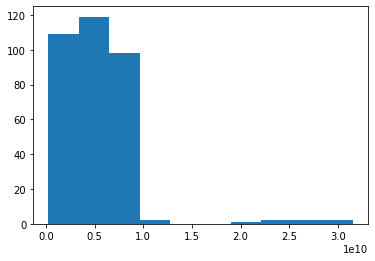

In [23]:
plt.hist(df['size'])

## Explore Size
First, let's represent size in MB for ease of conceptual understanding.

In [24]:
df['size_mb'] = [n/1024/1024 for n in df['size']]
df = df[['size_mb']]

In [25]:
df.describe()

,size_mb
count,335.000000
mean,5005.699422
std,3844.800553
min,248.909336
25%,2531.063938
50%,4545.482581
75%,6939.918686
max,30061.470526


### Split train/test

In [26]:
train = df[:'2019-10-17']
validate = df['2019-10-18':'2020-01-15']
test = df['2020-01-16':]

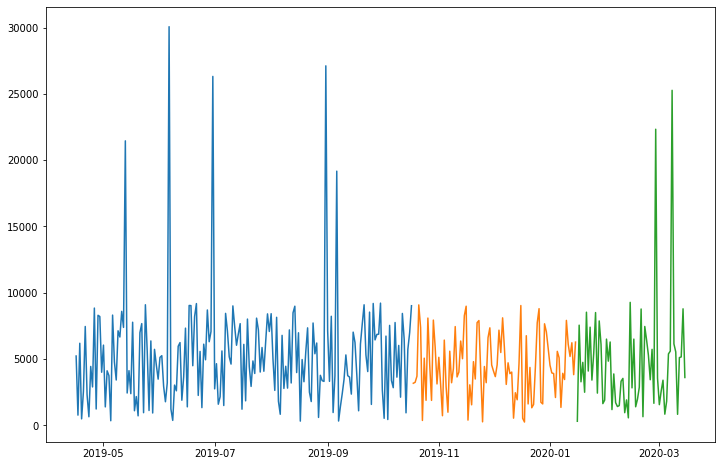

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(train)
plt.plot(validate)
plt.plot(test)
plt.show()

### Simple moving average

In [29]:
# 1 week
sma_short = train.rolling(window=7).mean()
sma_short[:10]

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,NaN
2019-04-17 00:00:00+00:00,NaN
2019-04-18 00:00:00+00:00,NaN
2019-04-19 00:00:00+00:00,NaN
2019-04-20 00:00:00+00:00,NaN
2019-04-21 00:00:00+00:00,NaN
2019-04-22 00:00:00+00:00,3570.222770
2019-04-23 00:00:00+00:00,2915.897461
2019-04-24 00:00:00+00:00,3440.297403


In [30]:
sma_long = train.rolling(window=30).mean()
sma_long[27:33]

,size_mb
timestamp,
2019-05-13 00:00:00+00:00,NaN
2019-05-14 00:00:00+00:00,NaN
2019-05-15 00:00:00+00:00,5116.205481
2019-05-16 00:00:00+00:00,5021.593648
2019-05-17 00:00:00+00:00,5255.127696
2019-05-18 00:00:00+00:00,5085.504811


Text(0, 0.5, 'Size (MB)')

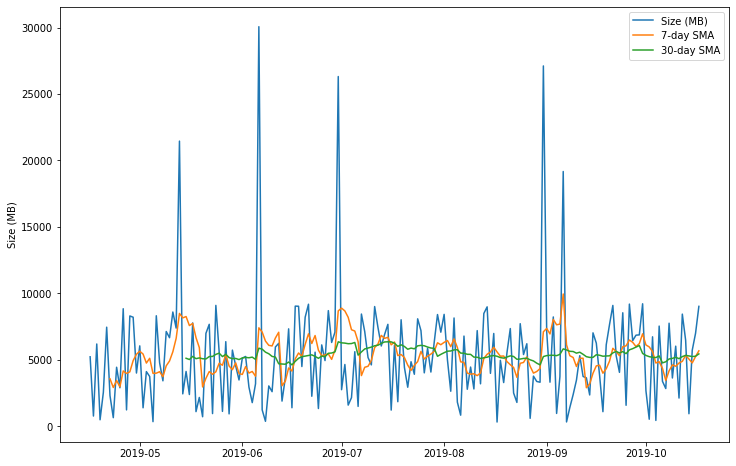

In [31]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, train, label='Size (MB)')

ax.plot(train.index, sma_short, label = '7-day SMA')

ax.plot(train.index, sma_long, label = '30-day SMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

## Exponential Moving Average
SMA time series are much less noisy than the time series of the original data points. The challenge with SMA, however, is that the values of SMA lag the original values. This means that changes in the trend are only seen with a delay (lag) of L time units.

Exponential Moving Average (EMA) helps reduce the lag induced by the use of the SMA. It does this by putting more weight on more recent observations, while the SMA weights all observations equally.

The EMA function looks like this:

$EMA_{t}= \alpha * (t_{0} - EMA_{t-1}) + EMA_{t-1}$

Where:
- M = Number of time periods, span of the window
- $t_{0}$ = Latest value
- $t-1$ = Previous value
- $EMA_{t-1}$ = Exponential moving average of previous day.
- The multiplier: $\alpha = \frac{2}{M+1}$

However, we will use the pandas ewm (Exponential Weighted functions) to compute our EMA. So we just need to define the following:
- M = span argument = number of time periods. We will use 1 week, which is $24*2*7 = 336$

In [32]:
ema_short = train.ewm(span=7).mean()
ema_short.head()

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,5226.592266
2019-04-17 00:00:00+00:00,2679.440056
2019-04-18 00:00:00+00:00,4197.303747
2019-04-19 00:00:00+00:00,2840.959930
2019-04-20 00:00:00+00:00,2748.725746


In [33]:
ema_long = train.ewm(span=30).mean()
ema_long.tail()

,size_mb
timestamp,
2019-10-13 00:00:00+00:00,5281.434608
2019-10-14 00:00:00+00:00,5001.491816
2019-10-15 00:00:00+00:00,5047.965405
2019-10-16 00:00:00+00:00,5173.569665
2019-10-17 00:00:00+00:00,5421.747542


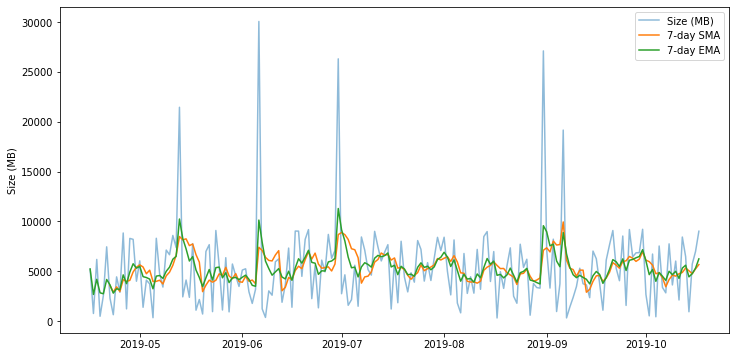

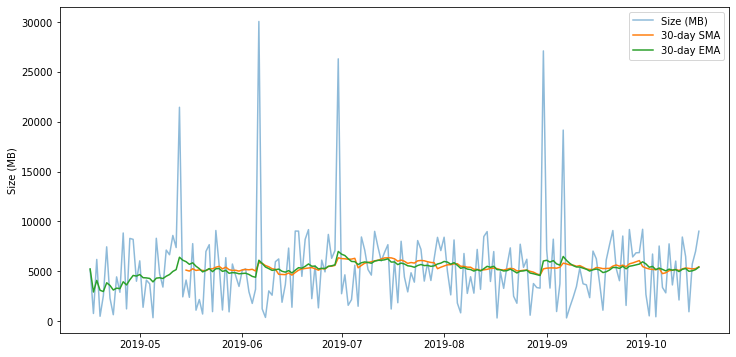

In [34]:
#Comparison of ema and sma

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, sma_short, label = '7-day SMA')
ax.plot(train.index, ema_short, label = '7-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(train.index, train, label='Size (MB)', alpha=.5)

ax.plot(train.index, sma_long, label = '30-day SMA')
ax.plot(train.index, ema_long, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

plt.show()


## Bollinger Bands and %b
Bollinger Bands
- a volatility indicator and commonly used in stock market trading.
- Made up of 3 lines, the Upper Band (UB), the Lower Band (LB) and the Midband.

Midband
- The Exponential Moving Average
- midband = train.ewm(span=30).mean()

Upper & Lower Band
- UB/LB = Midband +/- stdev * K
- stdev = train.ewm(span=30).std()
- K = the number of standard deviations to go up and down from the EMA

%b, Percent Bandwidth
- Shows where the last value sits in relation to the bands
- $\%b = \frac{last-LB}{UB-LB}$
- %b > 1 => point lies above UB
- %b < 0 => point lies below LB
- %b == .5 => point lies on the midband.

Bandwidth
- The width of the bands
- $Bandwidth = \frac{(UB-LB)}{Midband}$

In [35]:
# set the window span
span = 30

# compute midband
midband = train.ewm(span=span).mean()
midband

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,5226.592266
2019-04-17 00:00:00+00:00,2923.542143
2019-04-18 00:00:00+00:00,4085.550787
2019-04-19 00:00:00+00:00,3094.446301
2019-04-20 00:00:00+00:00,2972.749815
...,...
2019-10-13 00:00:00+00:00,5281.434608
2019-10-14 00:00:00+00:00,5001.491816
2019-10-15 00:00:00+00:00,5047.965405


In [36]:
# compute exponential stdev
stdev = train.ewm(span=span).std()
stdev

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,NaN
2019-04-17 00:00:00+00:00,3151.940050
2019-04-18 00:00:00+00:00,2911.088061
2019-04-19 00:00:00+00:00,2984.842070
2019-04-20 00:00:00+00:00,2552.928252
...,...
2019-10-13 00:00:00+00:00,3187.592888
2019-10-14 00:00:00+00:00,3268.137960
2019-10-15 00:00:00+00:00,3166.076391


In [37]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

ub

,size_mb
timestamp,
2019-04-16 00:00:00+00:00,NaN
2019-04-17 00:00:00+00:00,12379.362294
2019-04-18 00:00:00+00:00,12818.814969
2019-04-19 00:00:00+00:00,12048.972511
2019-04-20 00:00:00+00:00,10631.534570
...,...
2019-10-13 00:00:00+00:00,14844.213272
2019-10-14 00:00:00+00:00,14805.905695
2019-10-15 00:00:00+00:00,14546.194577


Text(0, 0.5, 'Size (MB)')

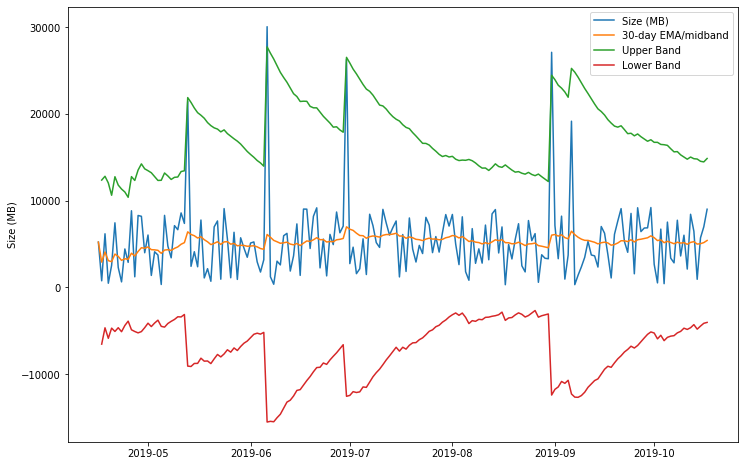

In [38]:
# plot the bands

fig, ax = plt.subplots(figsize=(12,8))

ax.plot(train.index, 
        train,
        label='Size (MB)')

ax.plot(train.index, 
        midband, 
        label = '30-day EMA/midband')
ax.plot(train.index, 
        ub, 
        label = 'Upper Band')
ax.plot(train.index, 
        lb, 
        label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Size (MB)')

Where do you think we will have a %b > 1?

Compute %b

$\%b = \frac{last-LB}{UB-LB}$

In [39]:
train = pd.concat([train, midband, ub, lb], axis=1)
train.columns = ['size_mb', 'midband', 'ub', 'lb']
train.tail()

,size_mb,midband,ub,lb
timestamp,,,,
2019-10-13 00:00:00+00:00,6478.857122,5281.434608,14844.213272,-4281.344055
2019-10-14 00:00:00+00:00,942.344555,5001.491816,14805.905695,-4802.922063
2019-10-15 00:00:00+00:00,5721.828842,5047.965405,14546.194577,-4450.263767
2019-10-16 00:00:00+00:00,6994.822309,5173.569665,14475.490229,-4128.350899
2019-10-17 00:00:00+00:00,9020.309903,5421.747542,14869.409348,-4025.914264


In [40]:
(7626 - (-3926.4))/(13060-(-3926))

0.6801130342635111

In [41]:
train['pct_b'] = (train['size_mb'] - train['lb'])/(train['ub'] - train['lb'])

In [42]:
train[train['pct_b']>1]

,size_mb,midband,ub,lb,pct_b
timestamp,,,,,
2019-06-06 00:00:00+00:00,30061.470526,6112.044813,27733.415159,-15509.325534,1.053837
2019-08-31 00:00:00+00:00,27109.296447,6033.508109,24465.697683,-12398.681465,1.071711


## Exercises
file name: time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb

Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.

Bonus:
Can you label students who are viewing both the web dev and data science curriculum? Can you label students by the program they are in? Can you label users by student vs. staff? What are Zach, Maggie, Faith, and Ryan's ids?

In [43]:
# acquiring data
df= pd.read_csv('anonymized-curriculum-access.txt', sep=" ", header=None)

# previewing data
df.head()

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [44]:
# preparing data

# setting column names
df.columns = ['date', 'time', 'page_viewed', 'user_id', 'cohort_id', 'ip']

# creating datetime column by combining date and time column
df["datetime"] = df["date"] + " " + df["time"]

# converting datetime column to datetime type
df.datetime = pd.to_datetime(df.datetime)

# setting datetime column as index
df = df.set_index('datetime')

# dropping separate date and time columns
df.drop(columns=['date', 'time'], inplace = True)

# previewing results
df.head()

,page_viewed,user_id,cohort_id,ip
datetime,,,,
2018-01-26 09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [50]:
df.index.

Int64Index([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
            ...
            16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
           dtype='int64', name='datetime', length=719459)